In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ddutils import *

import seaborn as sns # optional

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

The data for this paper can be obtained here
- [Link to all data](https://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluationhttps://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluationhttps://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluationhttps://www.sfmta.com/getting-around/drive-park/demand-responsive-pricing/sfpark-evaluation)
- Specific file: 'SFpark_ParkingSensorData_HourlyOccupancy_20112013.csv'

In [5]:
df = pd.read_csv('../SFpark_ParkingSensorData_HourlyOccupancy_20112013.csv')
print("Available Sub-Areas : ", df.PM_DISTRICT_NAME.unique())

/Users/Mitas/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Available Sub-Areas :  ['Fillmore' 'Downtown' 'Inner Richmond' 'West Portal' 'South Embarcadero'
 'Marina' "Fisherman's Wharf" 'Civic Center' 'Mission' 'Union' nan]


# Beach Street

In [6]:
beach_street_name = "BEACH ST"
beach_district_name = "Fisherman's Wharf"

In [7]:
df_beachst = df[(df.STREET_NAME==beach_street_name) & (df.PM_DISTRICT_NAME==beach_district_name)]
assert df_beachst.AREA_TYPE.unique() == ["Pilot"]
pre_occ_beach = df_beachst[(df_beachst['DAY_TYPE']=='weekday')]
beach_blocks = find_block_nums(df_beachst, beach_street_name)

# FO and ZO algorithms

In [153]:
def fo_zo_plotter(street_name, blk, starting_rate=2.00, timewin=(1200,1400), pre_loaded_dataset=None, print_diagnostics=False, pre_data=None):
    final_prices = dict()
    
    data = dict()
    
    num_of_hours = (timewin[1] - timewin[0]) // 100 + 1
    
    fig, axs = plt.subplots(1, 4, figsize=(40, 8), constrained_layout=True)
    
    index = 0
    
    occ = dataset_creator_weekdays_window(street_name + " " +str(blk), timewin=timewin, pre_loaded_dataset=pre_loaded_dataset)
    end_occ = average_occupancy_at_end(occ, 5, num_of_hours)
    q = occ[occ["RATE"]==starting_rate]
    
    sf_park_prices = sf_park_price_trajectory(occ, num_of_hours)
    sf_park_xcoords = [price[1] for price in sf_park_prices]
    sf_park_ycoords = [price[0] for price in sf_park_prices]
    
    m = estimate_m_from_final_occupancy(q, sf_park_ycoords[-1]-starting_rate, end_occ)
    print("m: {}".format(m))
    
    pairs=[(1,120), (4,30), (8,15), (15,8)]
    
    if pre_data:
        theta_opt = pre_data["theta_opt"]
    
    if not pre_data:
        seed = 1
        np.random.seed(seed)
        
        q_occ=np.asarray(pd.DataFrame.copy(q, deep=True)['OCCUPANCY_FRAC'])

        GAMMA=1*1e-3
        N=int(1e4) # number of samples for estimating empirical gradients

        delta = group_by_single_day_street(num_of_hours, occ)
        print("$\delta$: {}".format(delta))

        d0=np.asarray(pd.DataFrame.copy(q, deep=True)['OCCUPANCY_FRAC'])

        v=np.random.choice(d0,int(N), replace=True)
        theta_opt=-(np.mean(v)-0.7)*(m)/(GAMMA+(m)**2)
        
        data["theta_opt"] = theta_opt

        M = GAMMA+(m*1)**2

        theta=0.0
        N=int(1e6)
        R=2

        q_occ_=np.asarray(pd.DataFrame.copy(q, deep=True)['OCCUPANCY_FRAC'])

        alldata={}

        final_price_lst = []
        for p in pairs:

            n=p[0]; T=p[1]

            thetas_alg=[theta]
            eta=1/(GAMMA+(m*1)**2)
            if print_diagnostics:
                print()
                print("(n,T) : ", p)
                print("one bias term delta^n : ", delta**n)
                print("other bias term       : ", m*(GAMMA+m)*eta*delta**n/(1-delta**n))
                print("first bias.           : ", delta**(n*T))
                print(" recall optimal theta : ", theta_opt)
                print("step size: ", eta)

            d0=np.asarray(pd.DataFrame.copy(q, deep=True)['OCCUPANCY_FRAC'])


            for t in range(T):
                d0=run_dynamics(d0, q_occ_, m, thetas_alg[-1], n=n, delta=delta)
                grad_func_qt_=grad_func_theta_qt(m,GAMMA,d0,delta=delta,n=n, N=N, q_occ=q_occ_)
                thetas_alg.append(min(max(-1*R, thetas_alg[-1] - eta * grad_func_qt_(thetas_alg[-1])), R))

            if print_diagnostics:
                print('theta(T) : ', thetas_alg[-1])
                print()
                
            alldata[p]=thetas_alg
            if "alldata" not in data:
                data["alldata"] = dict()
            data["alldata"][p] = thetas_alg

    palette = ['xkcd:orange', 'xkcd:golden rod', 'xkcd:bright blue', 'xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple'] #sns.color_palette("tab10", 5)
    sns.set_style("whitegrid")

    if pre_data:
        alldata={}
        for p in pairs:
            alldata[p] = pre_data["alldata"][p]
    
    for i,p in enumerate(pairs):
        n=p[0]; T=p[1]
        total = n*T
        x_coords = range(0, total + 1, n)
        marker = '-o'
        if n <= 3:
            markersize = 8
        else:
            markersize=12

        y_coords = np.asarray(alldata[p])+starting_rate
#         final_price_lst.append(((n, T), y_coords[-1], estimate_occupancy(m, q, y_coords[-1]-starting_rate)))
        if index == 0:
            axs[index].plot(x_coords, y_coords, marker, color=palette[i], linewidth=4, markersize=markersize, label="n={},T={}".format(n, T))
        axs[index+2].plot(x_coords, np.clip(100*np.asarray([estimate_occupancy(m, q, y_coord-starting_rate) for y_coord in y_coords]), 0, 100), marker, color=palette[i], linewidth=4, markersize=markersize)

    if index == 0:
        axs[index].plot(sf_park_xcoords, sf_park_ycoords, marker, color="xkcd:green", linewidth=4, markersize=markersize, label="SF Park")
    axs[index+2].plot(sf_park_xcoords, 100*np.asarray([estimate_occupancy(m, q, y_coord-starting_rate) for y_coord in sf_park_ycoords]), marker, color="xkcd:green", linewidth=4, markersize=markersize)

#     final_price_lst.append(("SF Park", sf_park_ycoords[-1], estimate_occupancy(m, q, sf_park_ycoords[-1]-starting_rate)))
#     final_price_lst.append(("PO PRICE", theta_opt+starting_rate, estimate_occupancy(m, q, theta_opt)))
#     final_price_lst.append(("FINAL OCCUPANCY FROM DATA", sf_park_ycoords[-1], end_occ))

    if index == 0:
        axs[index].axhline(y=theta_opt+starting_rate, linestyle='--', color='xkcd:dark grey', linewidth=5)
    axs[index+2].axhline(y=70, linestyle=':', color='xkcd:black', linewidth=6)

    axs[index].set_xlabel('Iterations (weeks)', fontsize=36)
    axs[index].set_ylabel('Price (dollars)', fontsize=36)
    axs[index].set_ylim(1.5, 4)    # adjust to make figures fit
    axs[index].tick_params(labelsize=32)
    axs[index].set_title("{0} {1} FO".format(street_name, blk), fontsize=36)

    axs[index+2].set_xlabel('Iterations (weeks)', fontsize=36)
    axs[index+2].set_ylabel('Occupancy (%)', fontsize=36)
    axs[index+2].set_ylim(45, 105)    # adjust to make figures fit
    axs[index+2].tick_params(labelsize=32)
    axs[index+2].set_title("{0} {1} FO".format(street_name, blk), fontsize=36)

#     final_prices[blk] = final_price_lst
    index += 1

    if not pre_data:
    
        theta=0.0

        VAREPSILON = 0.25
        M=(GAMMA+(m*1)**2)+np.mean(q_occ)
        seeds=np.arange(1,100)
        alldata={}

        final_price_lst = []

        avgs={}
        stds={}
        vari={}

        for p in pairs:
            temp=[]
            for seed in seeds:
                np.random.seed(seed)

                n=p[0]; T=p[1]

                thetas_alg=[theta]

                eta=(1*M)**(-1) * T**(3*VAREPSILON-1)

                l_star=max([max([m*theta+qq for qq in q_occ_]) for theta in np.linspace(-R,R,1000)])

                mu=find_mu(l_star,eta,GAMMA)

                if print_diagnostics:
                    print()
                    print("mu :", mu)
                    print("(n,T) : ", p)
                    print("one bias term delta^n : ", delta**n)
                    print("other bias term       : ", m*(GAMMA+m)*eta*delta**n/(1-delta**n))
                    print("first bias.           : ", delta**(n*T))
                    print(" recall optimal theta : ", theta_opt)
                    print("step size: ", eta)

                for t in range(T):

                    v_t = sample_sphere(mu,1)
                    d0=run_dynamics(d0, q_occ_, m, thetas_alg[-1],n=n, delta=delta)
                    loss=loss_func_theta_qt(m,GAMMA,d0,delta=delta,n=n, N=N, q_occ=q_occ_)
                    gradest_=loss(thetas_alg[-1]+v_t) * v_t

                    entry = min(max(-1*R, thetas_alg[-1] - eta * gradest_), R)
                    if np.shape(entry) == (1,):
                        entry = entry[0]
                    thetas_alg.append(entry)    # unwrap the 1-D array to a scalar

                if print_diagnostics:
                    print('theta(T) : ', thetas_alg[-1])
                    print()
                alldata[p,seed]=thetas_alg

                temp.append(np.asarray(alldata[p,seed]))

            temp = np.asarray(temp)
            
            
            avgs[p]=np.mean(temp,axis=0)
            if "avgs" not in data:
                data["avgs"] = dict()
            data["avgs"][p] = avgs[p]
            
            stds[p]=np.std(temp,axis=0)
            if "stds" not in data:
                data["stds"] = dict()
            data["stds"][p] = stds[p]
            
            vari[p]=np.var(temp,axis=0)
            if "vari" not in data:
                data["vari"] = dict()
            data["vari"][p] = vari[p]

    if pre_data:
        avgs={}
        stds={}
        vari={}
        for p in pairs:
            avgs[p] = pre_data["avgs"][p]
            stds[p] = pre_data["stds"][p]
            vari[p] = pre_data["vari"][p]
            
    palette = ['xkcd:orange', 'xkcd:golden rod', 'xkcd:bright blue', 'xkcd:tomato red', 'xkcd:turquoise', 'xkcd:purple']
    sns.set_style("whitegrid")
    ci=0
    plotit = vari
    for i,p in enumerate(pairs):
        n=p[0]; T=p[1]
        total = n*T
        x_coords = range(0, total + 1, n)
        marker = '-o'
        if n <= 3:
            markersize = 8
        else:
            markersize=12

        y_coords = np.asarray(avgs[p])+starting_rate
#         final_price_lst.append(((n, T), y_coords[-1], estimate_occupancy(m, q, y_coords[-1]-starting_rate)))
        if index == 0:
            axs[index].plot(x_coords,np.asarray(avgs[p])+starting_rate,label="avg: n={}, T={}".format(n, T), linewidth=4, color=palette[ci], marker='o', markersize=markersize)
            axs[index+2].plot(x_coords,np.clip(100*np.asarray([estimate_occupancy(m, q, y_coord) for y_coord in np.asarray(avgs[p])]), 0, 100),label="avg: n={}, T={}".format(n, T), linewidth=4, color=palette[ci], marker='o', markersize=markersize)
        else:
            axs[index].plot(x_coords,np.asarray(avgs[p])+starting_rate, linewidth=4, color=palette[ci], marker='o', markersize=markersize)
            axs[index+2].plot(x_coords,np.clip(100*np.asarray([estimate_occupancy(m, q, y_coord) for y_coord in np.asarray(avgs[p])]), 0, 100), linewidth=4, color=palette[ci], marker='o', markersize=markersize)

        axs[index].plot(x_coords,(np.asarray(avgs[p])+starting_rate+np.asarray(plotit[p])).reshape(len(avgs[p]),), color=palette[ci], linestyle=':', alpha=0.5) #, label=r'$\pm 1$ std')
        axs[index].plot(x_coords,(np.asarray(avgs[p])+starting_rate-np.asarray(plotit[p])).reshape(len(avgs[p]),), color=palette[ci], linestyle=':', alpha=0.5)
        axs[index].fill_between(x_coords,(np.asarray(avgs[p])+starting_rate+np.asarray(plotit[p])).reshape(len(avgs[p]),),(np.asarray(avgs[p])+starting_rate-np.asarray(plotit[p])).reshape(len(avgs[p]),), alpha=0.2, color=palette[ci])

        axs[index+2].plot(x_coords,np.clip(100*(np.asarray([estimate_occupancy(m, q, y_coord) for y_coord in np.asarray(avgs[p])+np.asarray(plotit[p])])), 0, 100).reshape(len(avgs[p]),), color=palette[ci], linestyle=':', alpha=0.5) #, label=r'$\pm 1$ std')
        axs[index+2].plot(x_coords,np.clip(100*(np.asarray([estimate_occupancy(m, q, y_coord) for y_coord in np.asarray(avgs[p])-np.asarray(plotit[p])])), 0, 100).reshape(len(avgs[p]),), color=palette[ci], linestyle=':', alpha=0.5)
        axs[index+2].fill_between(x_coords,np.clip(100*(np.asarray([estimate_occupancy(m, q, y_coord) for y_coord in np.asarray(avgs[p])-np.asarray(plotit[p])])), 0, 100).reshape(len(avgs[p]),),np.clip(100*(np.asarray([estimate_occupancy(m, q, y_coord) for y_coord in np.asarray(avgs[p])+np.asarray(plotit[p])])), 0, 100).reshape(len(avgs[p]),), alpha=0.2, color=palette[ci])

        ci+=1

    axs[index].plot(sf_park_xcoords, sf_park_ycoords, marker, color="xkcd:green", linewidth=4, markersize=markersize)
    axs[index+2].plot(sf_park_xcoords, 100*np.asarray([estimate_occupancy(m, q, y_coord-starting_rate) for y_coord in sf_park_ycoords]), marker, color="xkcd:green", linewidth=4, markersize=markersize)


#     final_price_lst.append(("SF Park", sf_park_ycoords[-1], estimate_occupancy(m, q, sf_park_ycoords[-1]-starting_rate)))
#     final_price_lst.append(("PO PRICE", theta_opt+starting_rate, estimate_occupancy(m, q, theta_opt)))

    axs[index].axhline(y=theta_opt+starting_rate, linestyle='--', color='xkcd:dark grey', label='PO Price', linewidth=5)
    axs[index+2].axhline(y=70, linestyle=':', color='xkcd:black', label=r'Desired Occupancy', linewidth=6)

    axs[index].set_xlabel('Iterations (weeks)', fontsize=36)
    axs[index].set_ylabel('Price (dollars)', fontsize=36)
    axs[index].set_ylim(1.5, 4)    # adjust to make figures fit
    axs[index].tick_params(labelsize=32)
    axs[index].set_title("{0} {1} ZO".format(street_name, blk), fontsize=36)

    axs[index+2].set_xlabel('Iterations (weeks)', fontsize=36)
    axs[index+2].set_ylabel('Occupancy (%)', fontsize=36)
    axs[index+2].set_ylim(45, 105)    # adjust to make figures fit
    axs[index+2].tick_params(labelsize=32)
    axs[index+2].set_title("{0} {1} ZO".format(street_name, blk), fontsize=36)

#     final_prices[blk] = final_price_lst

    fig.legend(fontsize=36, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=7)
    fig.savefig('./figs/{0} {1}_all_occupancy.pdf'.format(street_name, blk), bbox_inches='tight')
    
    if not pre_data:
        return data

m: -0.15532294478114475
$\delta$: 0.958153801777585


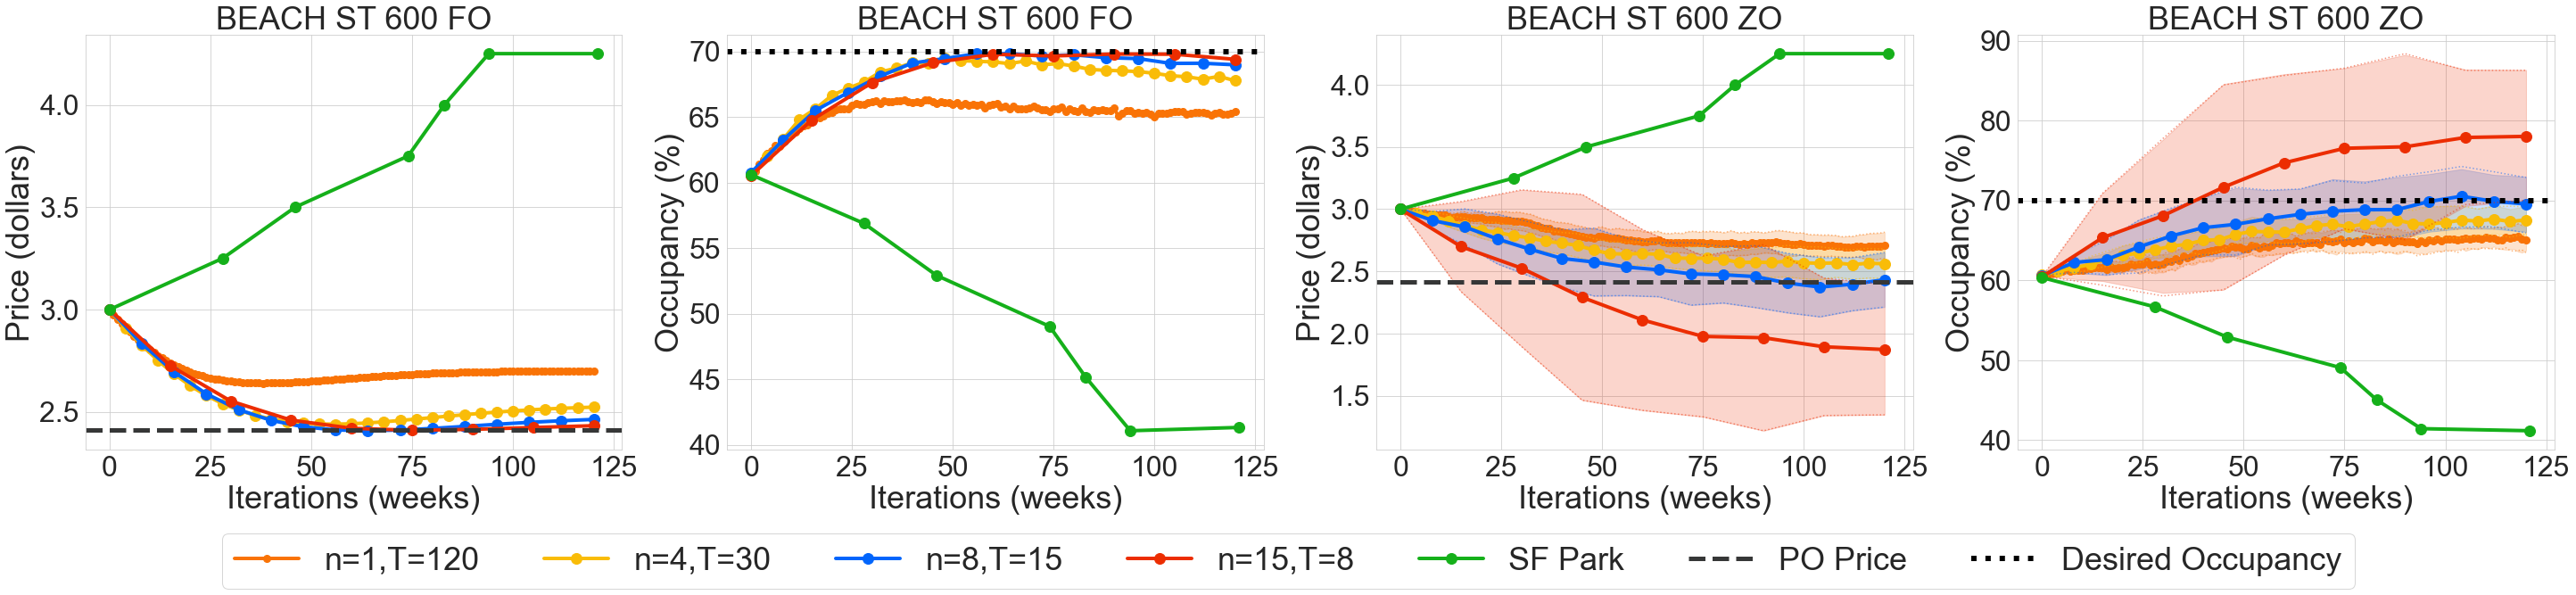

In [97]:
data_600 = fo_zo_plotter(beach_street_name, 600, 3.00, pre_loaded_dataset=pre_occ_beach)    # beach street rates start at 3.00

m: -0.15799712154882153


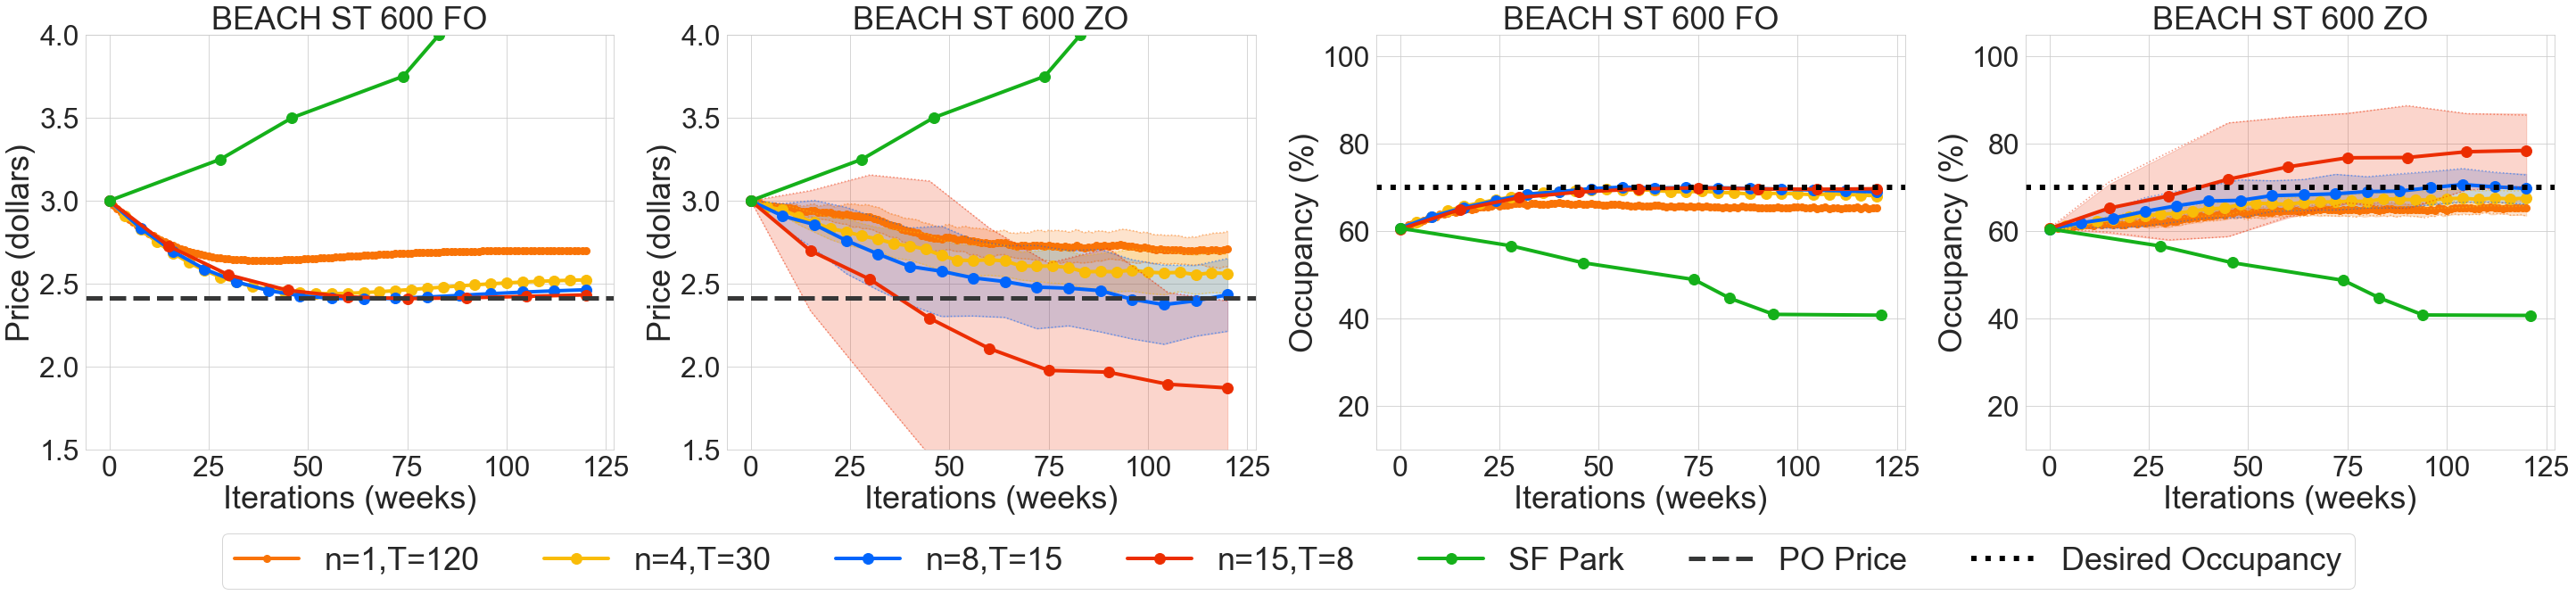

In [148]:
fo_zo_plotter(beach_street_name, 600, 3.00, pre_loaded_dataset=pre_occ_beach, pre_data=data_600)

m: -0.28752941751733413
$\delta$: 0.9932326155837577


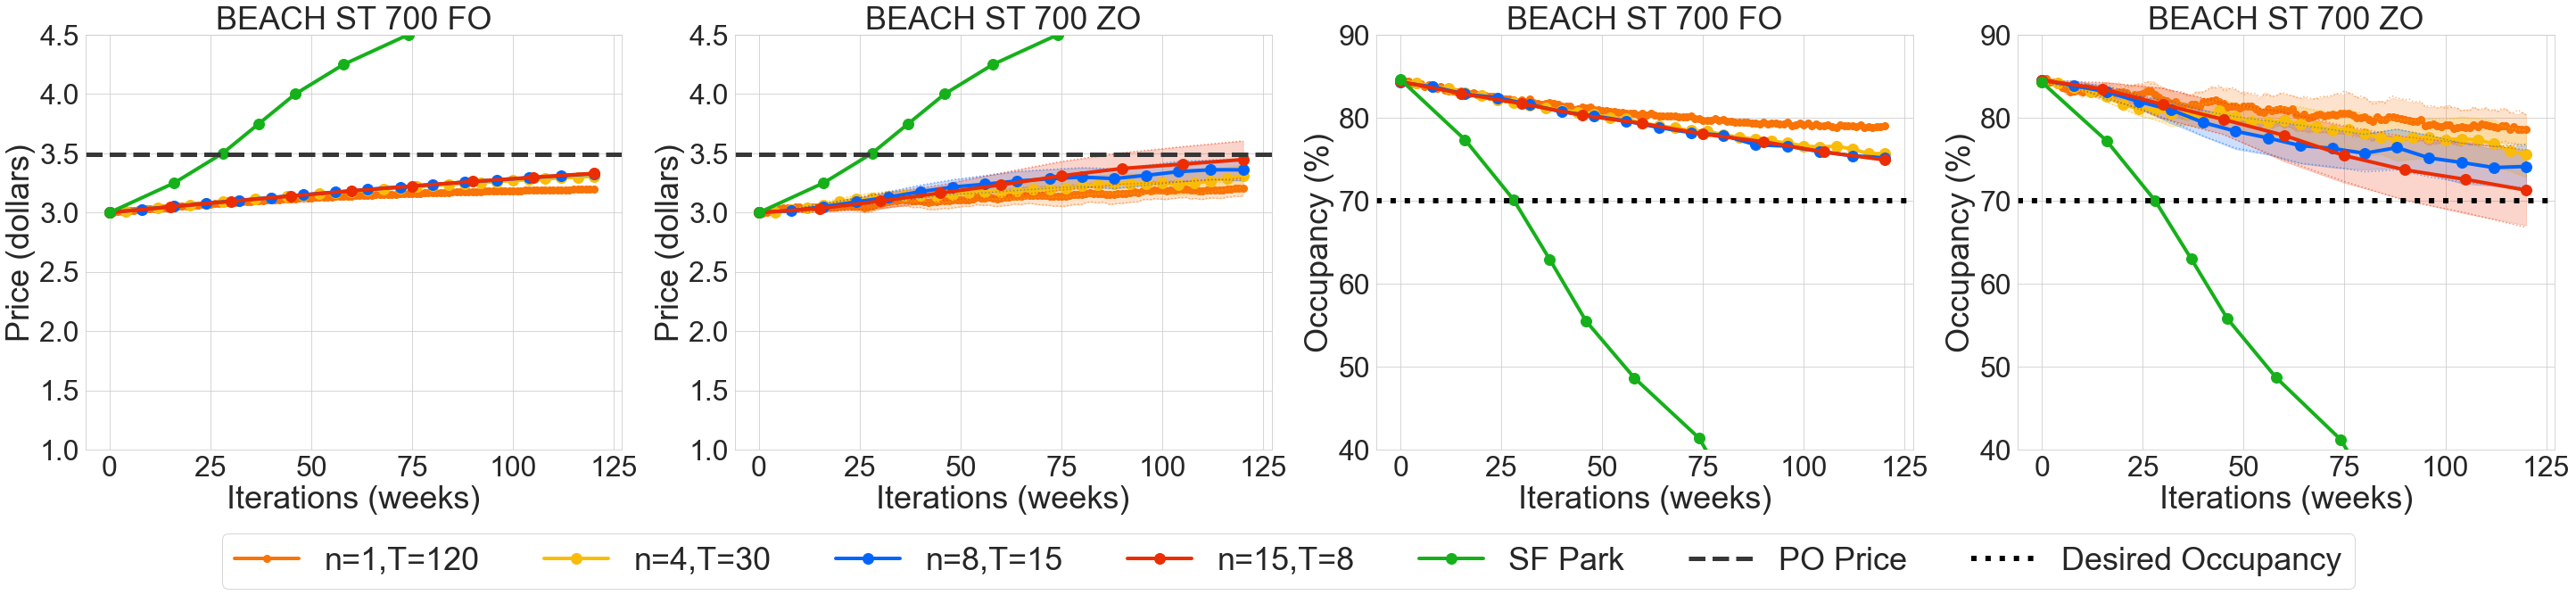

In [115]:
data_700 = fo_zo_plotter(beach_street_name, 700, 3.00, pre_loaded_dataset=pre_occ_beach)    # beach street rates start at 3.00

m: -0.28602577500577503


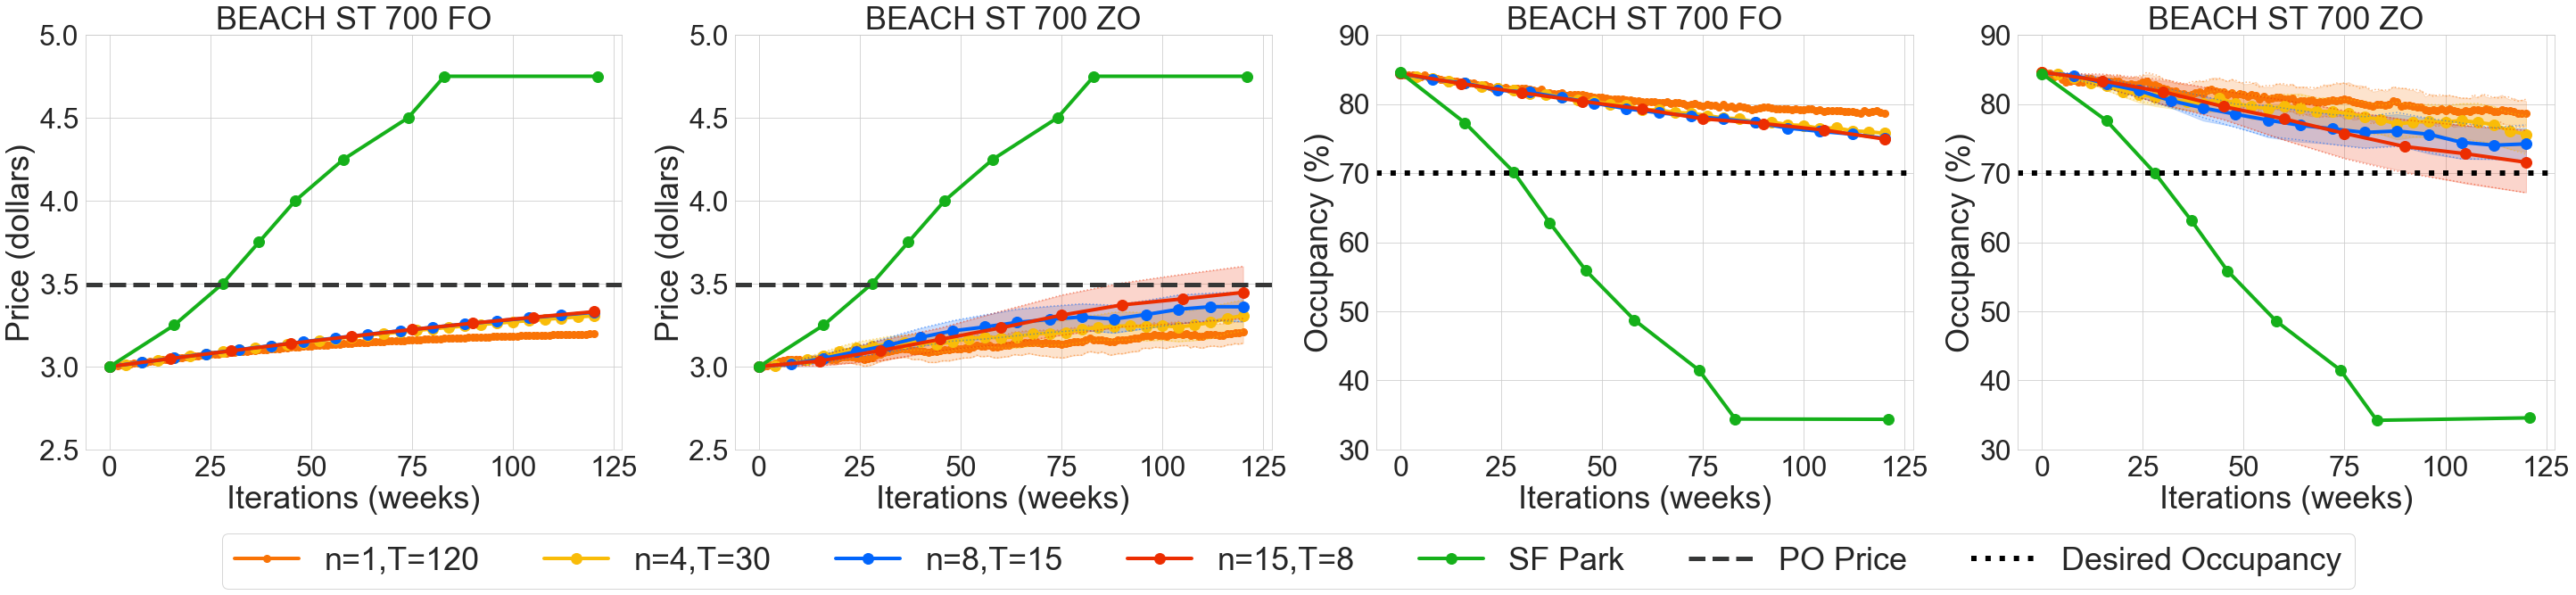

In [122]:
fo_zo_plotter(beach_street_name, 700, 3.00, pre_loaded_dataset=pre_occ_beach, pre_data=data_700)

m: -0.4244587985394044
$\delta$: 0.9839874138220652


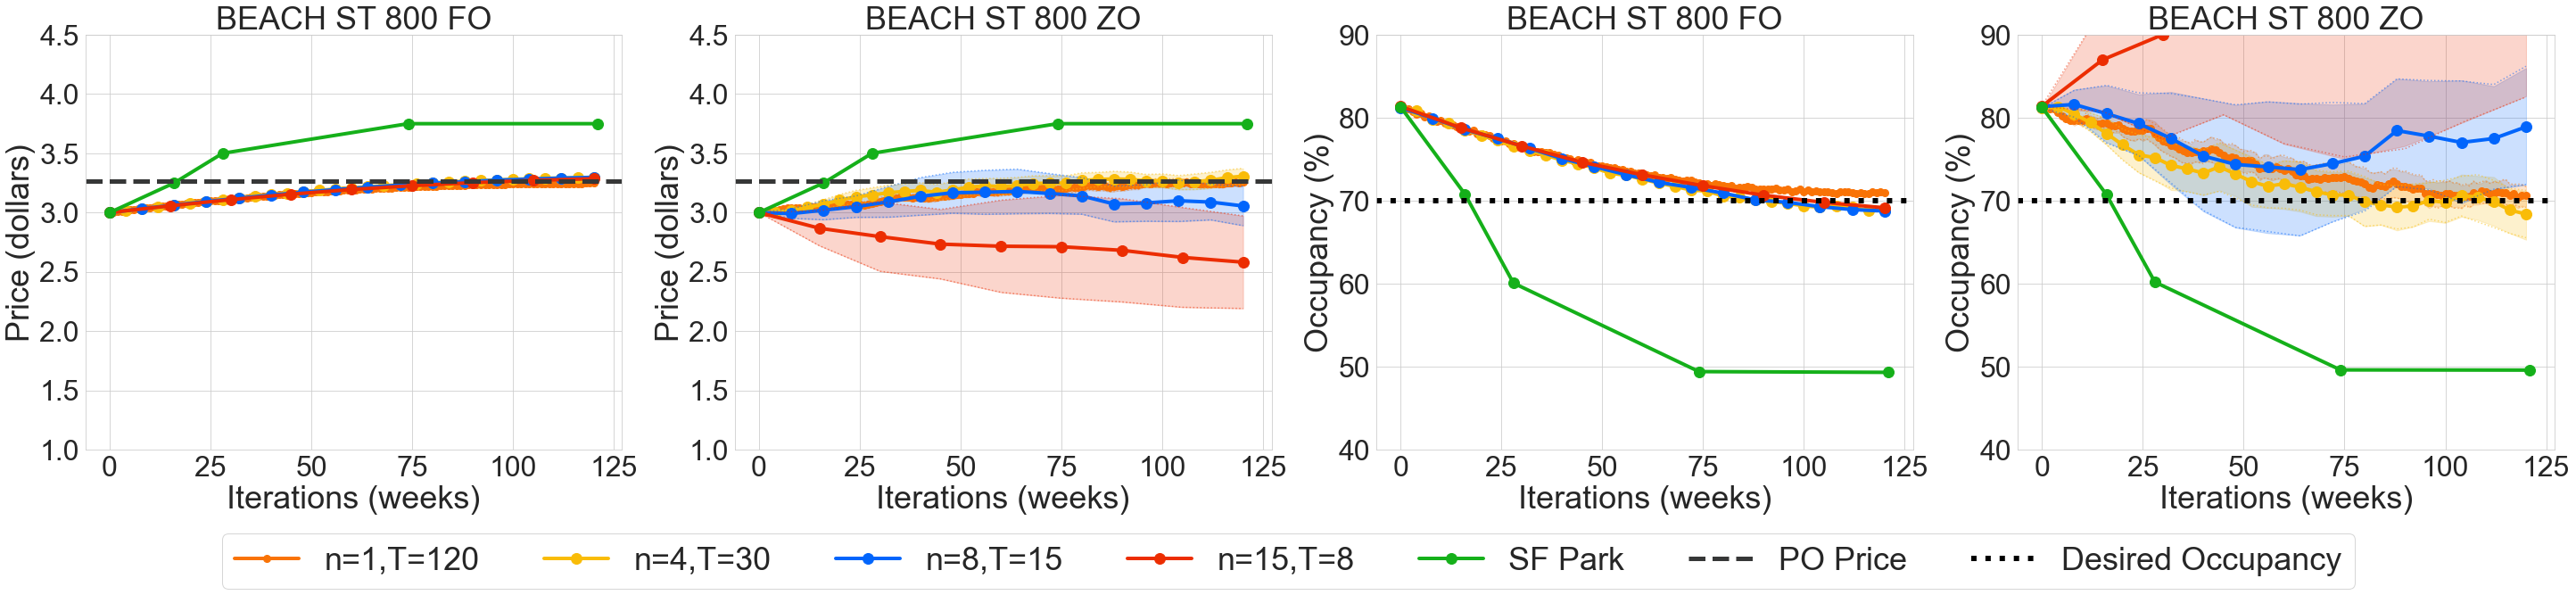

In [116]:
data_800 = fo_zo_plotter(beach_street_name, 800, 3.00, pre_loaded_dataset=pre_occ_beach)    # beach street rates start at 3.00

m: -0.42369996216050393


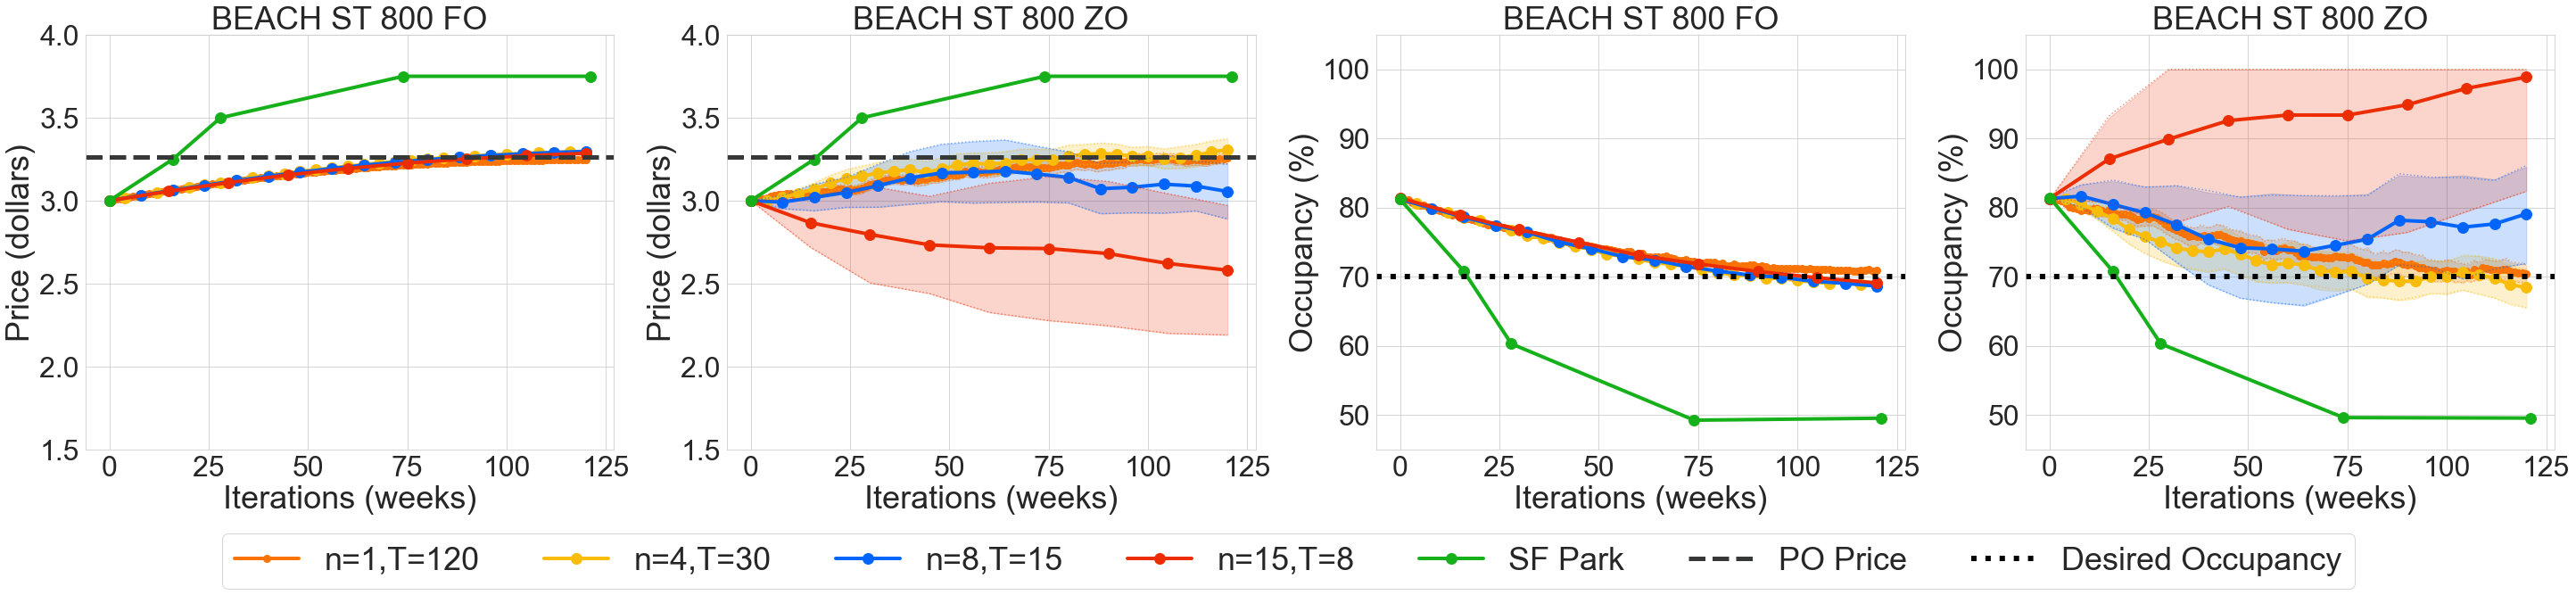

In [154]:
fo_zo_plotter(beach_street_name, 800, 3.00, pre_loaded_dataset=pre_occ_beach, pre_data=data_800)

m: -0.8476215500000002
$\delta$: 0.9927739431937314


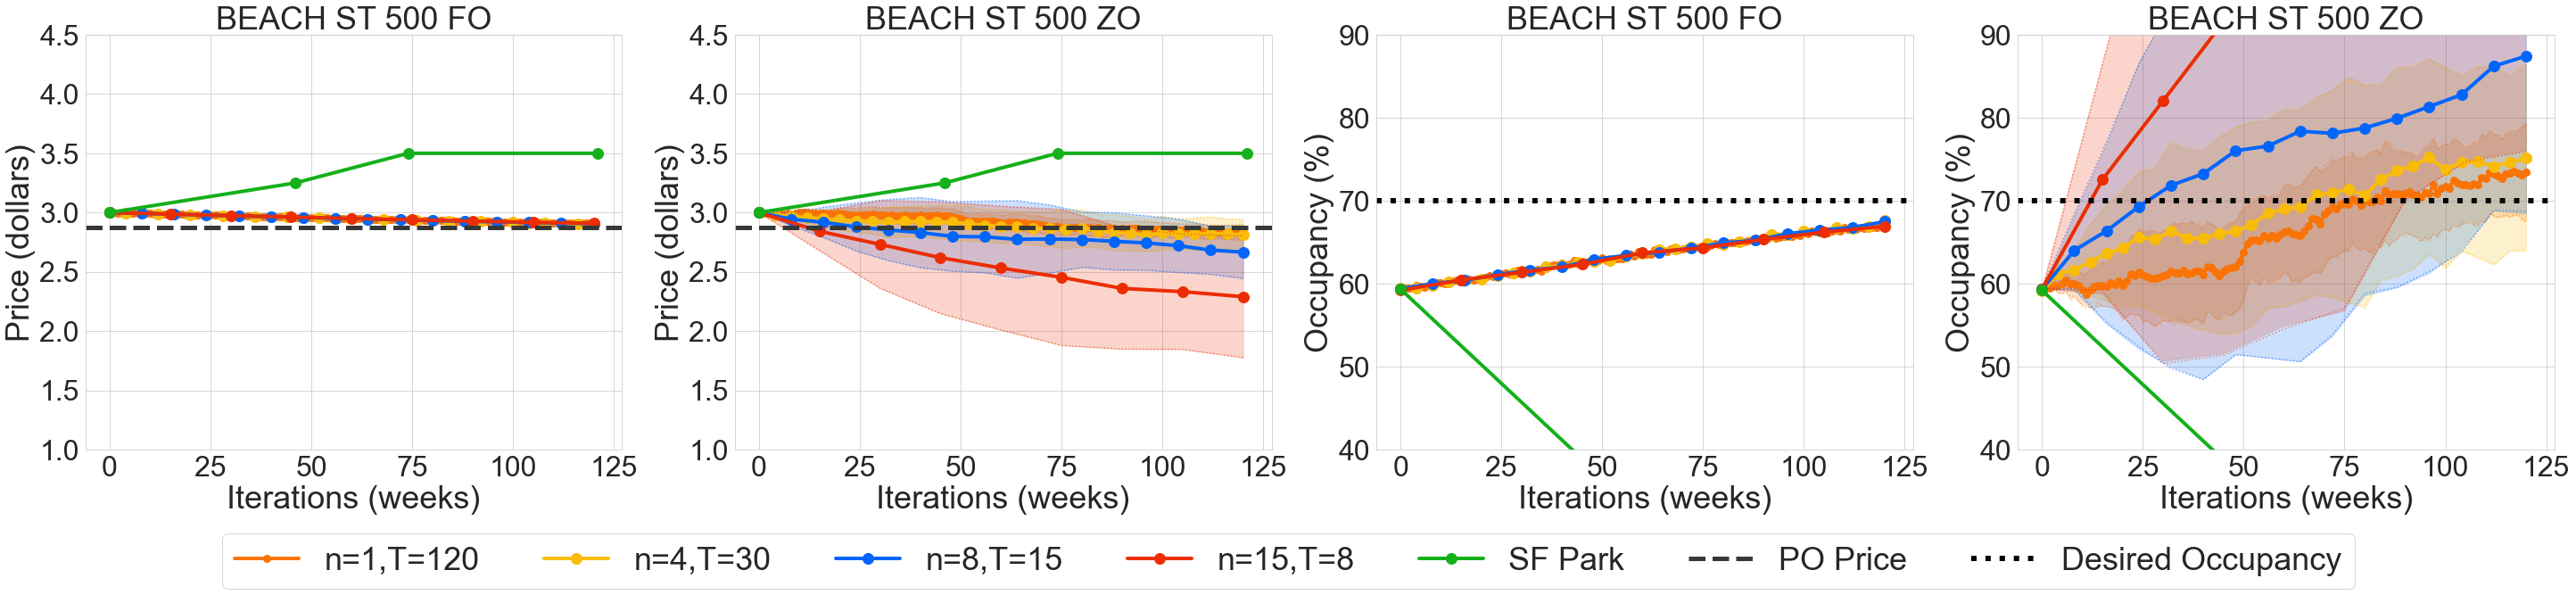

In [117]:
data_500 = fo_zo_plotter(beach_street_name, 500, 3.00, pre_loaded_dataset=pre_occ_beach)    # beach street rates start at 3.00

m: -0.843596777777778


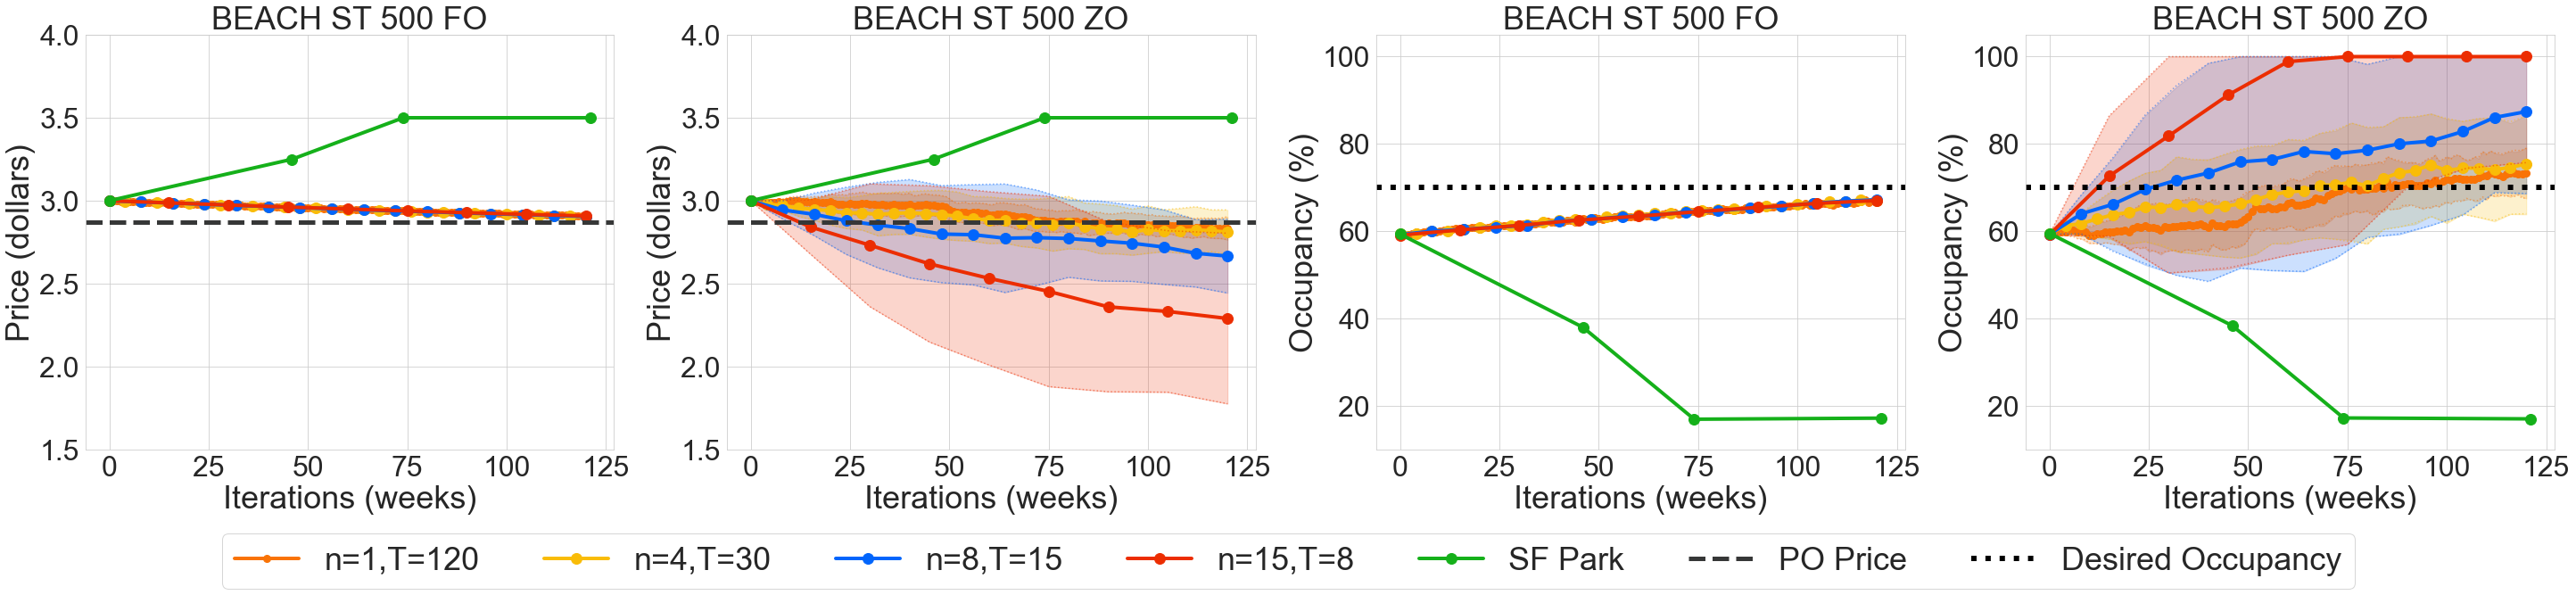

In [147]:
fo_zo_plotter(beach_street_name, 500, 3.00, pre_loaded_dataset=pre_occ_beach, pre_data=data_500)